# Development of lightweight sentiment classifier
## Step 1: Imports

In [1]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import torch
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score
#import kagglehub as kh

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 2: Load and trim data

In [3]:
#Dataset download from Kaggle
#path = kagglehub.dataset_download("aravsood7/sentiment-analysis-labelled-financial-news-data")
#print("Path to dataset files:", path)

#load in dataset
data = pd.read_csv("/content/drive/My Drive/Fin_Cleaned.csv") # Updated path
data.head()
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data.drop(columns=["Date_published"], inplace=True)
data.rename(columns={"Final Status" : "Sentiment"}, inplace=True)
print(data["Sentiment"].value_counts())
lmap = {"Positive": 1, "Negative": 0}
data["Sentiment"] = data["Sentiment"].map(lmap)
data.head()
data.dropna(inplace=True)

Sentiment
Positive     215
Negative     183
Positive       1
Name: count, dtype: int64


## Step 3: Create Train Test split

In [4]:
#creating train test splits which will allow us to train models
#and evaluate their performance and determine which feature most important

X_train, X_test, y_train, y_test = train_test_split(
    data[data.columns.tolist()[:-1]],
    data["Sentiment"],
    test_size=0.2,
    random_state=42,
    stratify=data["Sentiment"]
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=42,
    stratify=y_train
)


## Step 4: Load model

In [5]:
##tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

# Define tokenize globally so it's accessible everywhere
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

def experiment(text_col, run_name):
    # The tokenizer and tokenize functions are now global, no need to redefine them here
    # tokenizer = DistilBertTokenizerFast.from_pretrained(
    #     "distilbert-base-uncased"
    # )

    train_ds = Dataset.from_dict({
        "text": X_train[text_col].tolist(),
        "label": y_train.astype(int).tolist() # Cast labels to int
    }).map(tokenize, batched=True)

    val_ds = Dataset.from_dict({
        "text": X_val[text_col].tolist(),
        "label": y_val.astype(int).tolist()   # Cast labels to int
    }).map(tokenize, batched=True)

    train_ds.set_format("torch")
    val_ds.set_format("torch")

    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased-finetuned-sst-2-english",
        num_labels=2,
        problem_type="single_label_classification"
    )

    args = TrainingArguments(
      output_dir=f"./runs/{run_name}",
      eval_strategy="epoch",
      save_strategy="epoch",
      load_best_model_at_end=True,        # 🔑 REQUIRED
      metric_for_best_model="eval_loss",  # 🔑 what we monitor
      greater_is_better=False,            # loss ↓ is better
      learning_rate=2e-5,
      per_device_train_batch_size=16,
      per_device_eval_batch_size=16,
      num_train_epochs=5,                 # max epochs (early stop decides)
      report_to="none"
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        return {
            "accuracy": accuracy_score(labels, preds),
            "f1": f1_score(labels, preds, average="macro")
        }

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
    )


    trainer.train()
    return trainer

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Step 5: Run Experiement

In [6]:
results = {}
trainers = {}
#for col in data.columns.tolist()[:3]:
for col in data.columns.tolist()[:1]:
    print(f"\n🚀 Running experiment on: {col}")
    trainers[col] = experiment(col, f"distilbert_{col.lower()}")
    metrics = trainers[col].evaluate()
    results[col] = metrics


df_results = pd.DataFrame(results).T
print(df_results)



🚀 Running experiment on: Headline


Map:   0%|          | 0/286 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.610720,0.781250,0.775776
2,No log,0.513604,0.781250,0.775776
3,No log,0.533482,0.781250,0.775776


          eval_loss  eval_accuracy   eval_f1  eval_runtime  \
Headline   0.513604        0.78125  0.775776        0.1802   

          eval_samples_per_second  eval_steps_per_second  epoch  
Headline                  177.557                 11.097    3.0  


## Results
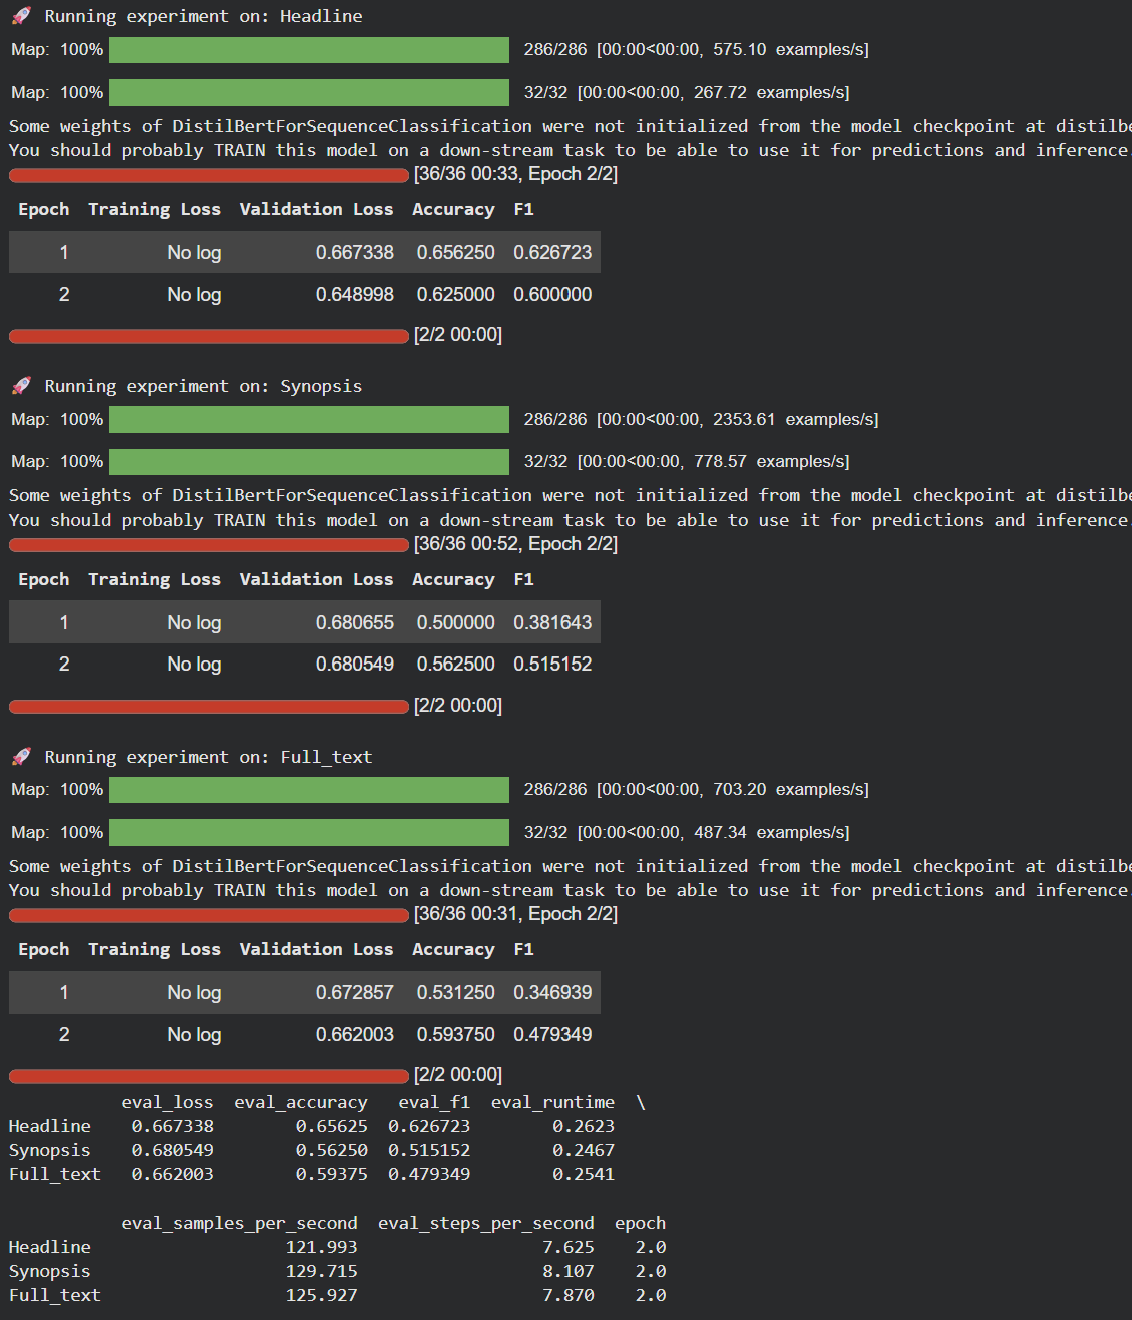

#### Base on the results of the tests, headlines eem to be the most accurate predictor. Trained and tested on "distilbert-base-uncased" with 2 epochs:
| Feature    | eval_loss | eval_accuracy |  eval_f1 | eval_runtime|
|------------|---|-------------|------------------|----------------|
| Headline      |  0.667338    |    0.65625 | 0.626723    |    0.2623   
| Synopsis      | 0.680549     |   0.56250 | 0.515152      |  0.2467   
| Full_text     | 0.662003     |   0.59375 | 0.479349       | 0.2541   
<br>
---  
<br>

##Final Breakdown

| Feature           |eval_samples_per_second | eval_steps_per_second | epoch |
|---------------|-------------|------------------|--------|
|Headline                |   121.993                |  7.625    |2.0  
|Synopsis                 |  129.715                 | 8.107    |2.0  
|Full_text                 | 125.927                  |7.870    |2.0  
<br>
---
<br>

### Now to test with "distilbert-base-uncased-finetuned-sst-2-english", only on headlines however

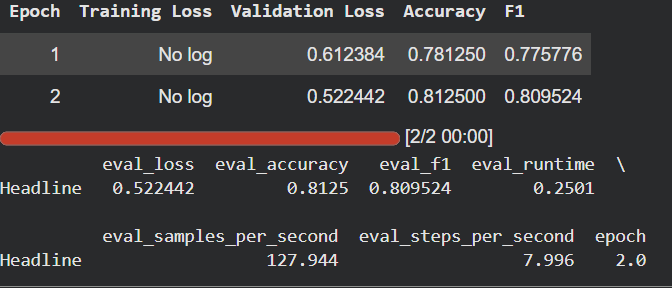

### Results indicate using the new variant yields much better results

In [7]:
best_col = df_results["eval_f1"].idxmax()
print("Best text column:", best_col)

test_ds = Dataset.from_dict({
    "text": X_test[best_col].tolist(),
    "label": y_test.astype(int).tolist() # Cast labels to int
}).map(tokenize, batched=True)

test_ds.set_format("torch")

trainers[best_col].evaluate(test_ds)

Best text column: Headline


Map:   0%|          | 0/80 [00:00<?, ? examples/s]

{'eval_loss': 0.5098121166229248,
 'eval_accuracy': 0.775,
 'eval_f1': 0.7737272155876807,
 'eval_runtime': 0.2929,
 'eval_samples_per_second': 273.121,
 'eval_steps_per_second': 17.07,
 'epoch': 3.0}

# Save Current model

## Specs:
### Yields around 78% accuracy
<ul>
<li> Epochs: 3 (Running 5 with patience of 1 to end early: avoid overfitting)
<li> Learning rate: 2e-5
<li> Max Length: 128
<li> Batch Length: 16
</ul>

In [9]:
# save models
BEST_DIR = "/content/drive/My Drive/models/distilbert_headline_v1" # Updated path to Google Drive

trainers[best_col].save_model(BEST_DIR)          # saves model + config
tokenizer.save_pretrained(BEST_DIR)   # saves tokenizer files

('/content/drive/My Drive/models/distilbert_headline_v1/tokenizer_config.json',
 '/content/drive/My Drive/models/distilbert_headline_v1/special_tokens_map.json',
 '/content/drive/My Drive/models/distilbert_headline_v1/vocab.txt',
 '/content/drive/My Drive/models/distilbert_headline_v1/added_tokens.json',
 '/content/drive/My Drive/models/distilbert_headline_v1/tokenizer.json')